## Set up

In [1]:
import sys
sys.path.append('./scripts/')

import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
sns.set_style("darkgrid")
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import imp
import my_datasets
import utilities 
imp.reload(my_datasets) 
imp.reload(utilities) 

/tmp/ipykernel_41742/2026189150.py:14: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'utilities' from '/home/laura/sw-interpretability/scripts/utilities.py'>

In [2]:
dataset='ilsvrc12'
paths, count, y, idx_to_labels = my_datasets.get_dataset(dataset)

print(count, len(paths))

10000 10000


In [3]:
layer='Mixed_7b.cat_2'
SAVEFOLD0=f'../outputs/{dataset}'

SAVEFOLD=f"{SAVEFOLD0}/{layer}/"

In [4]:
gradients_wrt_conv_layer=np.load(f"{SAVEFOLD}/gradients_wrt_conv_layer.npy")
predictions=np.load(f"{SAVEFOLD}/predictions.npy")
conv_maps=np.load(f"{SAVEFOLD}/conv_maps.npy")

pvh=np.load(f"{SAVEFOLD}/eigenvectors.npy",allow_pickle=True)

In [5]:
transforms = "standardise" # None / "standardise" / "normalise"

In [6]:
conv_maps_avg = conv_maps.mean(3).mean(2)

In [7]:
scale = StandardScaler()
normalise = MinMaxScaler()

standardised_data = scale.fit_transform(conv_maps_avg) 
normalised_data = normalise.fit_transform(conv_maps_avg) # .shape (10000, 2048)

In [8]:
if transforms == "standardise":
    activations = standardised_data
    print("Standardise")
elif transforms == "normalise": 
    activations = normalised_data
    print("Normaliseise")
else: 
    activations = conv_maps_avg
    print("Raw activations")

Standardise


In [9]:
# conv_maps_avg

In [10]:
# activations

In [11]:
pvh.shape

(2048, 2048)

## Utilities

In [12]:
def plot_ims_and_activations(neuron,top, maps = activations):
    print(f"\nNeuron {str(neuron)}")

    print(f"\n{top} maximally activating dataset example: ")
    top_ims = utilities.get_activations(activations_avg = maps, neuron = neuron).argsort()[-top:][::-1] 
    print(top_ims) # array([...]) 

    print(f"\n{top} corresponding highest activations: ")
    print(utilities.get_activations(activations_avg = maps, ims = top_ims, neuron=neuron)) 
    neurons_activated = dict()
    num_times_activated = dict()
    fig, ax = plt.subplots(top, 2, figsize=(2*6, top*6))
    ax = ax.flatten()
    for idx, image_id in enumerate(top_ims):
        im = Image.open(paths[image_id])
        ax[idx*2].imshow(im)
        ax[idx*2].axis('off')
        ax[idx*2].set_title(f"#{str(idx+1)} highest act.; Im. #{str(image_id)}; Act.: {str(round(utilities.get_activations(activations_avg = maps, ims = top_ims[idx], neuron=neuron),3))}") 
        ax[idx*2+1].plot(utilities.get_activations(activations_avg = maps, ims = image_id)) 
        ax[idx*2+1].set_title(f"Top neurons: {utilities.get_activations(activations_avg = maps, ims = image_id).argsort()[-10:][::-1]}", size=12)
        neurons_activated[image_id] = utilities.get_activations(activations_avg = maps, ims = image_id).argsort()[-top:][::-1] 
        for top_neuron in utilities.get_activations(activations_avg = maps, ims = image_id).argsort()[-top:][::-1]: 
            if top_neuron in num_times_activated:
                num_times_activated[top_neuron] += 1
            else:
                num_times_activated[top_neuron] = 1
    plt.show()
    num_times_activated = dict(sorted(num_times_activated.items(), key=lambda x:x[1], reverse=True))
    print("10 highest activating neurons for each image ID: ")
    for key, value in neurons_activated.items():
        print(key, ' : ', value)
    print("Number of times each top neuron is in list: ")
    print(num_times_activated)
    return neurons_activated, num_times_activated

In [13]:
def boxplot(neuron_list, ylim = 3, maps = activations):
    ax = sns.boxplot(utilities.get_activations(activations_avg = maps, neuron = neuron_list)) 
    ax.set_xticklabels(neuron_list)
    ax.set_ylim([0, ylim]) 

In [14]:
def plot_cosine_similarities(top_ims, min_sim=0.2, max_sim=1, maps = activations): 
    activations = utilities.get_activations(activations_avg = maps, ims = top_ims)
    activations_dot = np.empty([len(top_ims),len(top_ims)])
    activations_sim = np.empty([len(top_ims),len(top_ims)])
    for i in range(len(top_ims)):
        for j in range(len(top_ims)):
            activations_dot[i,j] = np.dot(activations[i], activations[j])
            activations_sim[i,j] = activations_dot[i,j]/(np.linalg.norm(activations[i])*np.linalg.norm(activations[j])) 

    ax = plt.subplot()
    im = ax.imshow(activations_sim, cmap='viridis', interpolation='nearest', vmin=min_sim, vmax=max_sim) 
    plt.title("Cosine similarities")
    plt.subplots_adjust(right=0.8)
    cbar_ax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(mappable=(im), cax=cbar_ax)
    plt.show()
    return activations_sim

In [15]:
def plot_cosine_similarities_without_neuron(top_ims, min_sim=0.2, max_sim=1, maps = activations): 
    activations = utilities.get_activations(activations_avg = maps, ims = top_ims) 
    activations_not = copy.copy(activations)
    activations_not = np.delete(activations_not, neuron, axis=1)
    activations_dot = np.empty([len(top_ims),len(top_ims)])
    activations_sim = np.empty([len(top_ims),len(top_ims)])
    for i in range(len(top_ims)):
        for j in range(len(top_ims)):
            activations_dot[i,j] = np.dot(activations_not[i], activations_not[j])
            activations_sim[i,j] = activations_dot[i,j]/(np.linalg.norm(activations_not[i])*np.linalg.norm(activations_not[j])) 

    ax = plt.subplot()
    im = ax.imshow(activations_sim, cmap='viridis', interpolation='nearest', vmin=min_sim, vmax=max_sim) 
    plt.title(f"Cosine similarities without neuron {neuron}")
    plt.subplots_adjust(right=0.8)
    cbar_ax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(mappable=(im), cax=cbar_ax)
    plt.show() 
    return activations_sim

In [16]:
def plot_pear_corr(top_ims, min_sim=None, max_sim=None, maps = activations): 
    activations = utilities.get_activations(activations_avg = maps, ims = top_ims)
    # activations.shape # (25, 2048)
    pear_corr = np.corrcoef(activations) # (50, 50) 
    ax = plt.subplot()
    im = plt.imshow(pear_corr, cmap='viridis', interpolation='nearest', vmin=min_sim, vmax=max_sim) 
    plt.title("Pearson correlation")
    plt.subplots_adjust(right=0.8)
    cbar_ax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.colorbar(mappable=(im), cax=cbar_ax)
    plt.show()
    return pear_corr

In [17]:
def neuron_cosine_similarities(top_ims, neuron, width = 0.4, maps = activations): 
    activations = utilities.get_activations(activations_avg = maps, ims = top_ims) 
    neuron_dot = np.empty([len(top_ims)])
    neuron_sim = np.empty([len(top_ims)])
    neuron_vec = np.zeros(2048)
    neuron_vec[neuron] = 1
    for i in range(len(top_ims)):
        neuron_dot[i] = np.dot(activations[i], neuron_vec)
        neuron_sim[i] = neuron_dot[i]/(np.linalg.norm(activations[i])) 
    plt.bar(range(len(neuron_sim)), neuron_sim, width = width)
    plt.show()
    return neuron_sim

In [18]:
def neuron_acts_and_cosine_similarities(top_ims, neuron, width = 0.4, maps = activations): 
    activations = utilities.get_activations(activations_avg = maps, ims = top_ims)
    neuron_dot = np.empty([len(top_ims)])
    neuron_sim = np.empty([len(top_ims)])
    neuron_vec = np.zeros(2048)
    neuron_vec[neuron] = 1
    for i in range(len(top_ims)):
        neuron_dot[i] = np.dot(activations[i], neuron_vec)
        neuron_sim[i] = neuron_dot[i]/(np.linalg.norm(activations[i])) 
    fig, ax = plt.subplots(2, 1)
    ax = ax.flatten()
    ax[0].bar(range(len(neuron_sim)), neuron_sim, width = width)
    ax[0].set_title(f"Cosine similarity of image with neuron {neuron} direction")
    ax[1].plot(range(len(top_ims)), activations[:,neuron])
    ax[1].set_title(f"Image activation for neuron {neuron}")
    ax[1].set_ylim(0, max(activations[:,neuron] + 0.2))
    plt.tight_layout()
    return neuron_sim

## Stanardardise and normalise data

<AxesSubplot: >

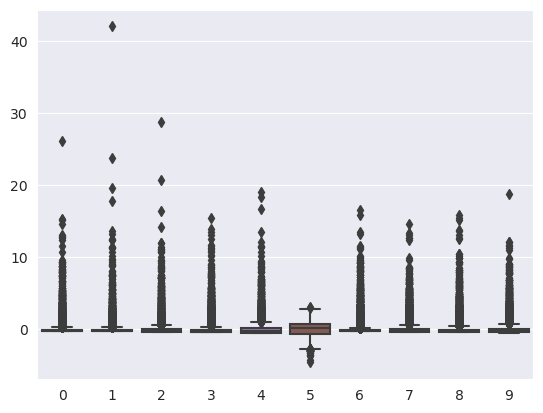

In [19]:
sns.boxplot(activations[:,1210:1220])

<AxesSubplot: >

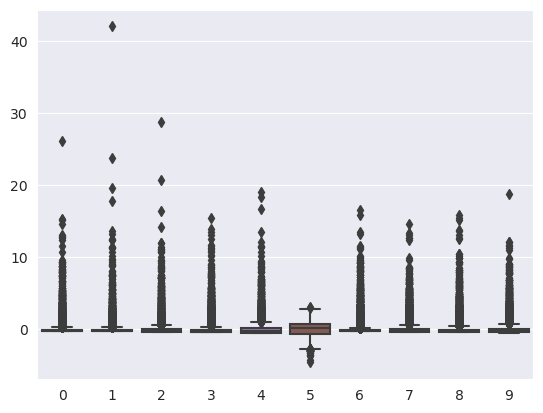

In [20]:
sns.boxplot(standardised_data[:,1210:1220])

<AxesSubplot: >

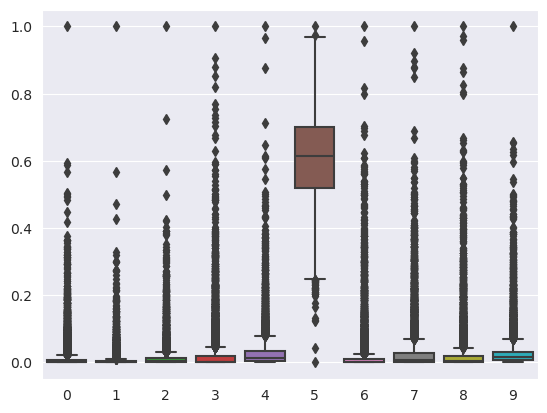

In [21]:
sns.boxplot(normalised_data[:,1210:1220])

In [22]:
standardised_data

array([[-0.19453002, -0.55699489,  0.49602738, ..., -0.42646365,
         2.47800132, -0.19513146],
       [-0.4811552 , -0.36254914, -0.00980556, ..., -0.37188355,
        -0.09907177, -0.26326883],
       [-0.5710877 , -0.59569609,  0.13117456, ..., -0.42646365,
        -0.42922297, -0.47148676],
       ...,
       [-0.62018972, -0.17212305,  0.17720605, ...,  8.04758243,
        -0.24000857, -0.47554872],
       [-0.08295891,  2.18514015, -0.46197014, ..., -0.37301702,
         0.48375618, -0.21264737],
       [-0.32225456, -0.34142135,  0.02046275, ..., -0.42646365,
         2.82586937, -0.47554872]])

In [23]:
normalised_data

array([[4.46541912e-02, 8.03902375e-03, 1.35218899e-01, ...,
        0.00000000e+00, 2.58230107e-01, 2.47365256e-02],
       [2.04815264e-02, 1.88372812e-02, 9.11809221e-02, ...,
        3.27366451e-03, 4.30544712e-02, 1.87259049e-02],
       [1.28970286e-02, 5.88980972e-03, 1.03454696e-01, ...,
        0.00000000e+00, 1.54881224e-02, 3.58317940e-04],
       ...,
       [8.75598745e-03, 2.94123128e-02, 1.07462213e-01, ...,
        5.08265575e-01, 3.12867932e-02, 0.00000000e+00],
       [5.40635919e-02, 1.60319445e-01, 5.18153297e-02, ...,
        3.20567984e-03, 9.17183508e-02, 2.31913898e-02],
       [3.38824845e-02, 2.00105818e-02, 9.38160911e-02, ...,
        0.00000000e+00, 2.87275744e-01, 0.00000000e+00]])

## Analyse polysemantic neurons

### Plot max activating images and activations

In [24]:
neurons_activated, num_times_activated = plot_ims_and_activations(direction = 35, top = 25)

TypeError: plot_ims_and_activations() got an unexpected keyword argument 'direction'

In [ ]:
neurons_activated, num_times_activated = plot_ims_and_activations(neuron =  27, top = 25)

In [ ]:
neurons_activated, num_times_activated = plot_ims_and_activations(neuron =  57, top = 50)

In [ ]:
print("\n10 highest activating neurons for each image ID:")
for key, value in neurons_activated.items():
    print(key, ' : ', value)
print("\nNumber of times each top neuron is in list:")
print(num_times_activated)

In [ ]:
# Look up neuron of interest to see if ther's an obvious pattern
plot_ims_and_activations(neuron = 1617, top = 25)

In [ ]:
neuron_list = [1215,27,35,57,70,74,93] 
boxplot(neuron_list)

### Neuron similarities

#### Neuron 35

In [ ]:
neuron = 35
top = 50 
top_ims = utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1] 

In [ ]:
activations.shape

In [ ]:
utilities.get_activations(activations_avg = activations, ims = top_ims).shape[1]

In [ ]:
plot_ims_and_activations(neuron = neuron, top = top)

In [ ]:
cosine_sim = plot_cosine_similarities(top_ims, min_sim=0.2, max_sim=1)

In [ ]:
cosine_sim_without_neuron = plot_cosine_similarities_without_neuron(top_ims)

In [ ]:
diff = cosine_sim - cosine_sim_without_neuron
diff.mean(1).mean(0) # average difference in cosine similarity with and without neuron

In [ ]:
_ = plot_pear_corr(top_ims)

In [ ]:
# try to clump together categories to see if closer cosing similarity
print(utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1])

top_ims_sorted = np.array((9488, 9484, 9480, 9483, 9489, 9482, 9485, # apples
                1343, 2350, 7012, 5223, 1768, 5860, 2359, # filed
                5224, 7523, 7683, # tennis/football...
                5609, 9810, 4299, 9813, 9819, 6772, 21, 
                5993)) # other
# for im in top_ims_sorted:
#     print("Image: " + str(im))
#     im = Image.open(paths[im])
#     im.show() 
fig, ax = plt.subplots(math.ceil(len(top_ims_sorted)//5), 5)
ax = ax.flatten()
for idx, im_id in enumerate(top_ims_sorted):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(im_id, size = 8)
    ax[idx].axis('off')

In [ ]:
# try to clump together categories to see if closer cosine similarity
print(utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1])

top_ims_sorted = np.array((9488, 9484, 9480, 9483, 9489, 9482, 9485, 9486, # apples
                1343, 2350, 7012, 9811, 7879, 5223, 5749, 6210, 7163, 8435, 5231, 4106, 6214, 9083, 9128, 5865, 
                5860, 2359, 2009, 1768, 1764, 1703, 1947, 2056, 2166, 1674, # filed
                5224, 7523, 7683, 9812, 9817, # tennis/football...
                5609, 9810, 4299, 9813, 9819, 6772, 21, 
                5993, 6211, 4905, 9439)) # other
# for im in top_ims_sorted:
#     print("Image: " + str(im))
#     im = Image.open(paths[im])
#     im.show() 
fig, ax = plt.subplots(math.ceil(len(top_ims_sorted)//5), 5, figsize = (10,20))  # change for 50 
ax = ax.flatten()
for idx, im_id in enumerate(top_ims_sorted):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(im_id, size = 8)
    ax[idx].axis('off')

In [ ]:
plot_cosine_similarities(top_ims_sorted, min_sim=0.0, max_sim=1)

In [ ]:
plot_pear_corr(top_ims_sorted)

In [ ]:
cosine_neuron = neuron_acts_and_cosine_similarities(top_ims, neuron)
cosine_neuron

#### Neuron 27

In [ ]:
neuron = 27
top = 50
top_ims  = utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1] 

In [ ]:
plot_ims_and_activations(neuron = neuron, top = top)

In [ ]:
plot_cosine_similarities(top_ims, min_sim=0.2, max_sim=1)

In [ ]:
cosine_neuron = neuron_cosine_similarities(top_ims, neuron)
cosine_neuron

In [ ]:
# try to clump together categories to see if closer cosing similarity
print(activations[:,neuron].argsort()[-top:][::-1])
print(utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1])

top_ims_sorted = np.array((5826, 5824, 4545, 7131, 5617, 4983, 9205, 8607, 6606, # shelves etc
                           1947, 1927, 1045, 1828, 2082, 2089, 2022, 2025, 1945, 
                           2092, 2672, 2436, 1664, 2073, 2739, 2912))
# for im in top_ims_sorted:
#     print("Image: " + str(im))
#     im = Image.open(paths[im])
#     im.show() 
fig, ax = plt.subplots(math.ceil(len(top_ims_sorted)//5), 5)
ax = ax.flatten()
for idx, im_id in enumerate(top_ims_sorted):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(im_id, size = 8)
    ax[idx].axis('off')

In [ ]:
# try to clump together categories to see if closer cosine similarity
print(utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1])

top_ims_sorted = np.array((5826, 5824, 4545, 5827, 6928, 5617, 5193, 4983, 9205, 
                           8607, 7131, 6606, 6240, 5556, 4219, 4541, 5214, 
                           5271, 4819, 4816, 7980, 8583,  # shelves etc
                           1947, 1927, 1045, 1828, 2082, 2089, 2022, 2025, 1945, 
                           2092, 2672, 2436, 1664, 2073, 2087, 1890, 1824, 
                           2469, 1864, 2165, 1602, 1944, 2739, 2736, 2781, 1725, 2912, 2862 # dogs
                           ))
# for im in top_ims_sorted:
#     print("Image: " + str(im))
#     im = Image.open(paths[im])
#     im.show() 
fig, ax = plt.subplots(math.ceil(len(top_ims_sorted)//5), 5, figsize = (10,20))
ax = ax.flatten()
for idx, im_id in enumerate(top_ims_sorted):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(im_id, size = 8)
    ax[idx].axis('off')

In [ ]:
plot_cosine_similarities(top_ims_sorted, min_sim=0.0, max_sim=1)

#### Neuron 57

In [ ]:
neuron = 57
top = 50
top_ims  = utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1] 

In [ ]:
plot_ims_and_activations(neuron = neuron, top = top)

In [ ]:
top_ims

In [ ]:
plot_cosine_similarities(top_ims, min_sim=0.2, max_sim=1)

In [ ]:
cosine_neuron = neuron_cosine_similarities(top_ims, neuron, width = 0.6)
cosine_neuron

In [ ]:
# try to clump together categories to see if closer cosing similarity
print(utilities.get_activations(activations_avg = activations, neuron = neuron).argsort()[-top:][::-1])

top_ims_sorted = np.array((1970, 2679, 2334, 1963, 1991, 1992, 1971, 
                           1973, 2051, 2052, 1990, 1899, 2267, 2424, 
                           2055, 2670, # black fluffy dogs
                           2336, 1772, 2191, 2168, 1566, 2044, 1766, 
                           2285, 2172, 2171, 2320, 2170, 2580, # other dogs
                           8308, 5934, 9348, 6828, 5394, 8447, 5935, 
                           9193, 9196, 6838, 8813, 5938, 9192, 8684, 8599, 
                           5933, 9343, 6336, 4540, 7998, 7982)) # diagonal rectangle
# for im in top_ims_sorted:
#     print("Image: " + str(im))
#     im = Image.open(paths[im])
#     im.show() 
fig, ax = plt.subplots(math.ceil(len(top_ims)//5), 5, figsize = (10,20))
ax = ax.flatten()
for idx, im_id in enumerate(top_ims_sorted):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(im_id, size = 8)
    ax[idx].axis('off')

In [ ]:
plot_cosine_similarities(top_ims_sorted, min_sim=0.0, max_sim=1)

## RW

In [ ]:
top = 100

neuron = 1215

print("\nmaximally activating dataset example: ")
print(np.argmax(conv_maps_avg[:,neuron])) # 5205

print("\n10 maximally activating dataset example: ")
top_ims = conv_maps_avg[:,neuron].argsort()[-top:][::-1]
print(top_ims) # array([...])

print("\n10 corresponding highest activations: ")
print(conv_maps_avg[top_ims,neuron])

for idx, im in enumerate(top_ims):
    print("Top " + str(idx) + " activation; Image number: " + str(im) + "; Activation: " + str(conv_maps_avg[top_ims[idx],neuron]))
    im = Image.open(paths[im])
    im.show() 

In [ ]:
top = 25
neuron = 27

print(f"\nNeuron {str(neuron)}")
      
# print(f"\nmaximally activating dataset example: {np.argmax(conv_maps_avg[:,neuron])}")

print(f"\n{top} maximally activating dataset example: ")
top_ims = conv_maps_avg[:,neuron].argsort()[-top:][::-1]
print(top_ims) # array([...])

print(f"\n{top} corresponding highest activations: ")
print(conv_maps_avg[top_ims,neuron])

fig, ax = plt.subplots(top, 2, figsize=(2*6, top*6))
ax = ax.flatten()
for idx, image_id in enumerate(top_ims):
    im = Image.open(paths[image_id])
    ax[idx*2].imshow(im)
    ax[idx*2].axis('off')
    ax[idx*2].set_title(f"#{str(idx+1)} highest act.; Im. #{str(image_id)}; Act.: {str(round(conv_maps_avg[top_ims[idx],neuron],3))}") 
    ax[idx*2+1].plot(conv_maps_avg[image_id])
    ax[idx*2+1].set_title(f"Top neurons: {conv_maps_avg[image_id].argsort()[-10:][::-1]}", size=12)
plt.show()

In [ ]:
def plot_ims_and_activations(neuron,top):
    print(f"\nNeuron {str(neuron)}")

    # print(f"\nmaximally activating dataset example: {np.argmax(conv_maps_avg[:,neuron])}")

    print(f"\n{top} maximally activating dataset example: ")
    top_ims = conv_maps_avg[:,neuron].argsort()[-top:][::-1]
    print(top_ims) # array([...])

    print(f"\n{top} corresponding highest activations: ")
    print(conv_maps_avg[top_ims,neuron])
    
    fig, ax = plt.subplots(top, 2, figsize=(2*6, top*6))
    ax = ax.flatten()
    for idx, image_id in enumerate(top_ims):
        im = Image.open(paths[image_id])
        ax[idx*2].imshow(im)
        ax[idx*2].axis('off')
        ax[idx*2].set_title(f"#{str(idx+1)} highest act.; Im. #{str(image_id)}; Act.: {str(round(conv_maps_avg[top_ims[idx],neuron],3))}") 
        ax[idx*2+1].plot(conv_maps_avg[image_id])
        ax[idx*2+1].set_title(f"Top neurons: {conv_maps_avg[image_id].argsort()[-10:][::-1]}", size=12)
    plt.show()

### Scale and normalise data

In [ ]:
# need to scale each neuron to mean 0 std 1
# need neurons at axis 1 so transpose
# conv_maps_avg_tr = np.transpose(conv_maps_avg)
# scaled_data_tr = scale.fit_transform(conv_maps_avg_tr) 
# scaled_data = np.transpose(scaled_data_tr)
# print(scaled_data_tr.shape) # scaled_data_tr.shape (2048, 10000)
# print(scaled_data.shape) # scaled_data.shape (10000, 2048)
# print("scaled_data_tr.mean(0)", scaled_data_tr.mean(0))
# print("scaled_data_tr.mean(1)", scaled_data_tr.mean(1))
# print("scaled_data.mean(0)", scaled_data.mean(0))
# print("scaled_data.mean(1)", scaled_data.mean(1))
# print("scaled_data.mean(0).shape", scaled_data.mean(0).shape) # (2048,)
# print("scaled_data.mean(1).shape", scaled_data.mean(1).shape) # (10000,)
# print(scaled_data) 

In [ ]:
# scaled_data_test = scale.fit_transform(conv_maps_avg) 
# scaled_data_test.shape # (10000, 2048)
# scaled_data_test[:,1210:1220].shape # (10000, 10)
# scaled_data_test.mean(0).shape # (2048,)
# scaled_data_test.mean(0)[1210:1220] # array([-5.46385159e-16, -1.14526166e-15,  1.69295689e-15, -2.77267098e-16,
#         6.95166147e-17,  2.48987497e-15,  9.26964061e-16,  1.48356882e-15,
#         6.90825175e-16,  2.31342723e-16])
# scaled_data_test.std(0)[1210:1220] # array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])